## Investigating Changes in Spin Rates Between 2016 and 2019

## Introduction 

Brian "Bubba" Harkins worked for the Los Angeles Angels for 38 years before he was fired in March 2020 [(Halos Heaven)](https://www.halosheaven.com/2021/1/8/22220863/los-angeles-angels-mlb-news-scandal-brian-bubba-harkins). Harkins had been accused of providing a mixture of pine tar and rosin to players around Major League Baseball. Since his dismissal, Harkins has filed a lawsuit against MLB and the Angels. contending that "MLB and the Angels have artificially created a one-person scandal" [(ESPN)](https://www.espn.com/mlb/story/_/id/30671790/fired-los-angeles-angels-clubhouse-attendant-names-pitchers-ball-doctoring-case). In the lawsuit, Harkins claims that he provided his pine tar-rosin mixture (nicknamed "Go-Go Juice") [(LA Times)](https://www.latimes.com/sports/angels/story/2020-03-06/angels-employee-bubba-harkins-sold-homemade-substance-pitchers-applied-to-baseballs) to current and former Angels: Troy Percival, Brendan Donnelly, Kevin Jepsen, Cam Bedrosian, Keynan Middleton, Yusmeiro Petit, Luke Bard, Matt Andriese, Dylan Peters, Jose Suarez, Kaleb Cowart and Dylan Bundy; as well as other pitchers around MLB, many of them aces: Gerrit Cole, Justin Verlander, Edwin Jackson, Max Scherzer, Felix Hernandez, Corey Kluber, Joba Chamberlain, Adam Wainwright and Tyler Chatwood (ESPN). 

For decades, pitchers have used rosin and pine tar, along with other substances, to gain a better grip on the ball. However, this phenomenon has mostly happened behind closed doors. Very occasionally, a pitcher might be thrown out of a game if a foreign substance were detected on his person [(see, for example, Michael Pineda)](https://www.youtube.com/watch?v=BaOjaFN3gqM). The Harkins lawsuit has brought doctoring baseballs out into the open. This year, MLB has started collecting baseballs after games, and plans to analyze spin rates in hopes of catching pitchers who use foreign substances to doctor baseballs [(NY Times)](https://www.nytimes.com/2021/03/24/sports/baseball/foreign-substance-ball-doctoring.html). Trevor Bauer, who plays for the LA Dodgers, has been particularly outspoken about how many pitchers in MLB frequently use substances to help grip baseballs better and boost spin rates, even accusing the Astros pitching staff of doing so in 2018 [(Sports Illustrated)](https://www.si.com/mlb/2018/05/02/trevor-bauer-houston-astros-spin-rate-pine-tar). Now, Bauer finds himself at the center of MLB's investigation, likely in part because of his willingness to speak up [(NY Times)](https://www.nytimes.com/2021/04/09/sports/baseball/trevor-bauer-dodgers.html). 

As Bauer has argued in the past, and as the recent lawsuit suggests, other pitchers are likely guilty of using substances to grip baseballs better, boost spin rates, and subsequently achieve more movement on their pitches. Indeed, the lawsuit presents an interesting opportunity to evaluate spin rates for specific pitchers. Here, I wanted to know whether Gerrit Cole, who was traded to the supposedly-cheating Astros in 2018, had higher spin rates after he was traded. I compare Gerrit Cole's spin rates before and after the trade, also using a number of qualified pitchers who were also named in the Harkins lawsuit for further comparison.

For this comparison, I used Statcast data retrieved from [Baseball Savant](https://baseballsavant.mlb.com/), which catalogues spin rate and pitch type for every pitch thrown during a season of baseball. I also used a Player ID Map, housed by [Smart Fantasy Baseball](https://www.smartfantasybaseball.com/tools/), which contains player names and MLBIDs, facilitating the retrieval of data from the pitchers named in the lawsuit. This project focuses on four seasons of Statcast data, from 2016 through 2019: two seasons before the Gerrit Cole trade, and two seasons after. 

Statcast data is subject to frequent analysis by data scientists at all ages and stages. To my knowledge, no other study has compared spin rates for the pitchers named in the Bubba Harkins lawsuit to date, although--as I alluded to above--MLB claims it will analyze spin rate using Statcast data to identify pitchers using foreign substances.

## Data wrangling: Statcast data, Gerrit Cole's pitch mix, trade timing, and mean spin rates

In general, Statcast data has information on player names, and instead relies on the `MLBID` identifier. I joined Statcast data with the taxonomy from Smart Fantasy Baseball and subsetted four seasons of Statcast data (2016-2019) using names of players mentioned by Bubba Harkins in the lawsuit. Following a join on `MLBID`, I saved a .csv file using the code in the Appendix.

In the first chunk below, I read in the data, keeping only specific columns that I thought would be useful: the name of the pitcher, the game date, the name of the pitch thrown, and the spin rate on release (in RPM). I kept two full seasons before Gerrit Cole was traded, and two full seasons after. 

In [1]:
# load important packages 
from datascience import *
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind as ttest_ind 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
# read in the cleaned data
clean_statcast_data = Table.read_table('clean_statcast_data.csv', low_memory=False)

# subset with important columns
clean_statcast_data = clean_statcast_data.select(['PLAYERNAME','game_date','pitch_name','release_spin_rate'])

# keep two years before and after the Cole trade
clean_statcast_data = clean_statcast_data.sort('game_date', descending = False).where('game_date', are.between('2016-04-01', '2019-10-14'))

clean_statcast_data.show(1) # show one row of the table

SyntaxError: invalid syntax (<unknown>, line 1)

I made a table containing only statistics for Gerrit Cole. I was curious what his most thrown pitches were, so I created a table, and then a barplot, that would let me check.

Text(0.5, 1.0, 'Gerrit Cole Pitch Breakdown')

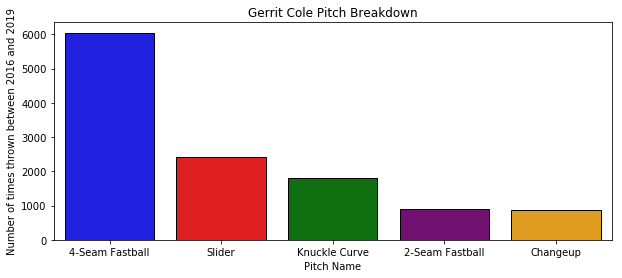

In [144]:
gc_table = clean_statcast_data.where('PLAYERNAME', 'Gerrit Cole')

gc_pitch_table = gc_table.select('pitch_name').group('pitch_name').sort('count', descending = True)

gc_most_thrown = gc_pitch_table.take(0, 1, 2, 3, 4)

plt.figure(figsize=(10,4))
sns.barplot(x = 'pitch_name', y = 'count', data = gc_most_thrown.to_df(), palette = ['blue','red','green', 'purple', 'orange'])
plt.xlabel('Pitch Name')
plt.ylabel('Number of times thrown between 2016 and 2019')
plt.title('Gerrit Cole Pitch Breakdown')

I made the decision to subset by three of these five most-thrown pitches: the 4-Seam Fastball, the Knuckle Curve, and the Slider. My reasoning was that these pitches are each thrown in very different ways. Analyzing three differently-thrown pitches could help test whether some pitches are more affected by doctoring baseballs than others.

In [146]:
gc_table = gc_table.where('pitch_name', are.contained_in(['4-Seam Fastball', 'Knuckle Curve', 'Changeup']))

gc_table.show(1)

PLAYERNAME,game_date,pitch_name,release_spin_rate
Gerrit Cole,2016-04-09,4-Seam Fastball,2133


I realized that replicating the same specificity of analysis across all of the pitchers named by Harkins in the lawsuit would be nearly impossible. Pitchers mix up their pitches differently, and some (like Gerrit Cole) throw a rare pitch that other pitchers might not throw at all. But the four-seam fastball is ubiquitous, and could provide a basis for comparison of spin rates between pitchers named in the Harkins lawsuit.

I wrote a series of functions to help me work with the data. The first function returns a list of qualified pitchers (in this case, 'qualified' refers to pitchers who threw a given pitch more than 800 times during the given time period. Assuming that pitchers started about 33 games per season, that means they threw the pitch slightly more than 6 times per appearance). 

In [147]:
relevant_pitchers = qualified_pitchers(clean_statcast_data, np.unique(clean_statcast_data['PLAYERNAME']),'4-Seam Fastball')

The second function returns relevant data before or after a given date and extracts rows for which the spin rate is not missing; in this case, the date I chose was April 1st, 2018 (which would be right before the start of the 2018 season, when Gerrit Cole first started playing for the Astros).

In [148]:
before_cole_trade = before_or_after_date(clean_statcast_data, relevant_pitchers,'4-Seam Fastball','2018-04-01', before = True)

after_cole_trade = before_or_after_date(clean_statcast_data, relevant_pitchers,'4-Seam Fastball','2018-04-01', before = False)

The third function returns mean spin rates of a pitch for a given set of pitchers. Applied together, these functions helped me get the data ready for visualization and analysis.

In [149]:
before_spin_rates = mean_spin_rate(before_cole_trade, np.unique(before_cole_trade['PLAYERNAME']),'4-Seam Fastball')

after_spin_rates =  mean_spin_rate(after_cole_trade, np.unique(after_cole_trade['PLAYERNAME']),'4-Seam Fastball')

## Visualize the data: Spin rates, and differences in spin rates, over time

The first plot I created was a Gerrit Cole-specific figure, visualizing spin rates for three of his pitches during the two seasons before the Astros trade and the two seasons after. 

Text(0.5, 1.0, 'Spin Rates for Gerrit Cole Before and After the Astros Trade')

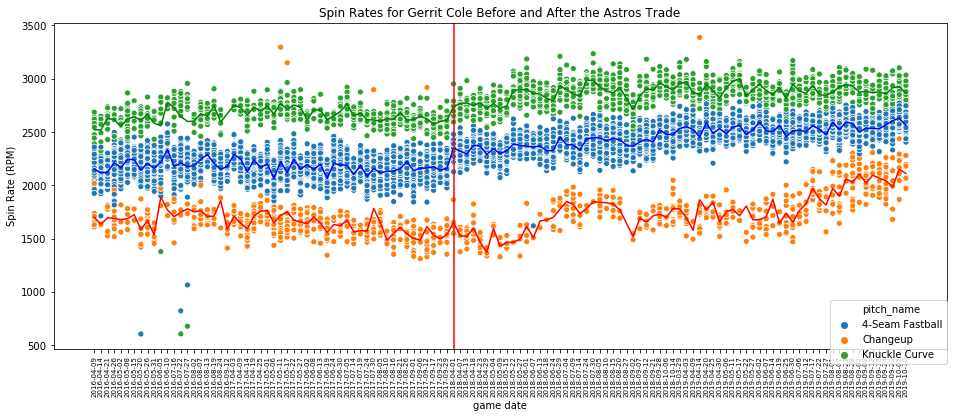

In [114]:
# mean by game date, for the line part of the visualization
gc_means = gc_table.group(['pitch_name', 'game_date'], np.nanmean)

# the visualization itself
plt.figure(figsize=(16,6))
sns.scatterplot('game_date', 'release_spin_rate', data = gc_table.to_df(), hue = 'pitch_name')
plt.xticks(rotation = 90)
sns.lineplot('game_date', 'release_spin_rate nanmean', data = gc_means.to_df(), palette = ['blue', 'red', 'green'], hue = 'pitch_name', legend=False)
plt.axvline('2018-04-01', color = 'red')
plt.tick_params(axis = 'x', labelsize = 7)
plt.legend(bbox_to_anchor=(1, 0.15), loc=1, borderaxespad=0.)
plt.xlabel('game date')
plt.ylabel('Spin Rate (RPM)')
plt.title('Spin Rates for Gerrit Cole Before and After the Astros Trade')

This figure shows the spin rate for every 4-Seam Fastball (blue), Changeup (orange), and Knuckle Curve (green) thrown by Gerrit Cole during between the beginning of the 2016 season and the end of the 2019 season. Each correspondingly colored line charts the mean spin rate for each of these pitches. The vertical red line (at 2018-04-01) denotes Cole's move to the Astros, the time after which he was accused of doctoring baseballs. After the vertical red line, there appears to be a pronounced uptick in spin rate across all of Cole's pitches, which seems to support the notion that Cole made a change to his routine on the mound.

In my next figure, I wanted to assess whether the changes in spin rates indeed reflected an uptick.

Text(0, 0.5, 'Spin Rate Difference (RPM)')

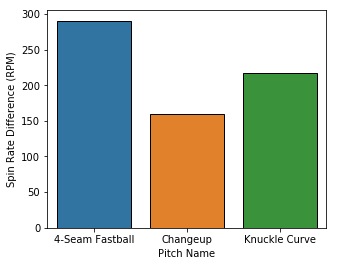

In [142]:
gc_before = before_or_after_date(clean_statcast_data, 'Gerrit Cole', ['4-Seam Fastball', 'Knuckle Curve', 'Changeup'],'2018-04-01', before = True)
gc_after = before_or_after_date(clean_statcast_data, 'Gerrit Cole', ['4-Seam Fastball', 'Knuckle Curve','Changeup'],'2018-04-01', before = False)
gc_mean_before = gc_before.select('pitch_name', 'release_spin_rate').group('pitch_name', np.nanmean)
gc_mean_after = gc_after.select('pitch_name', 'release_spin_rate').group('pitch_name', np.nanmean)
gc_differences = gc_mean_after['release_spin_rate nanmean'] - gc_mean_before['release_spin_rate nanmean']
gc_differences = Table().with_columns('pitch_name', gc_mean_before['pitch_name'], 'spin rate difference', gc_differences)

plt.figure(figsize = (5,4))
sns.barplot(x = 'pitch_name', y = 'spin rate difference', data = gc_differences.to_df())
plt.xlabel('Pitch Name')
plt.ylabel('Spin Rate Difference (RPM)')

Indeed, Gerrit Cole's mean spin rates increased after he waas traded for the pitches studied here.

The third figure, below, shows the relative change in spin rates in the two seasons leading up to the Gerrit Cole trade and the two seasons immediately following the Gerrit Cole trade for twelve qualified pitchers. In this case, 'qualified' means that these pitchers threw more than 800 4-Seam Fastballs in MLB action between 2016 and 2019. All of these pitchers were named by Bubba Harkin in the lawsuit he filed against the Angels and MLB. Thus, they serve as an important set of pitchers to whom Cole (and the spin rate on his 4-Seam Fastball) should be compared.

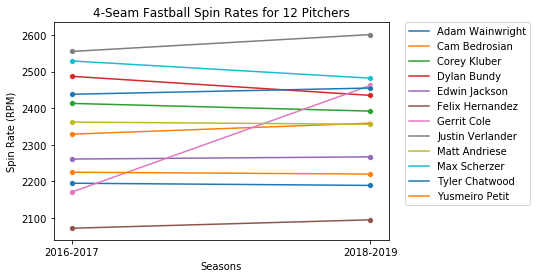

In [150]:
for i in range(len(before_spin_rates['spin_rate'])):     
    sns.scatterplot(['2016-2017','2018-2019'], [before_spin_rates['spin_rate'][i], after_spin_rates['spin_rate'][i]])
    sns.lineplot(['2016-2017','2018-2019'],[before_spin_rates['spin_rate'][i], after_spin_rates['spin_rate'][i]])
    plt.legend(before_spin_rates['PLAYERNAME'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Seasons')
    plt.ylabel('Spin Rate (RPM)')
    plt.title('4-Seam Fastball Spin Rates for 12 Pitchers')

While there do appear to be some pitchers who experienced a slight bump in spin rate between 2016 and 2019, Gerrit Cole's increase in spin rate after he was traded in the Astros represents an increase in spin rate far greater than any other pitcher during the same span. Cole's trade to the Astros precipitated an increase in spin rate large enough to suggest that he made some drastic changes in how he threw--or doctored--baseballs upon arrival in Houston.

I thought it would also be useful to visualize the changes in spin rate by taking the difference between mean spin rates in 2018-2019 and 2016-2017. 

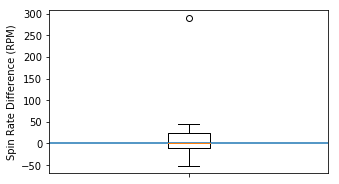

In [151]:
diffs = after_spin_rates['spin_rate'] - before_spin_rates['spin_rate']

plt.figure(figsize = (5, 3))
Table().with_column('', diffs).boxplot()
plt.ylabel('Spin Rate Difference (RPM)')
plt.axhline(0)

If every pitcher in the lawsuit were doctoring baseballs more after Gerrit Cole was traded to the Astros, we would expect the distribution of spin rate differences to be shifted above zero. That said, the distribution appears centered around zero, and Cole is the biggest outlier by far. This result suggests that he may have been doctoring baseballs more after he was traded to the Astros. 

## Analyses: Assessing increases in spin rate 


First, I wanted to know if the increases in spin rate that Gerrit Cole experienced across all three of his pitches were statistically significant. I decided to run t-tests to compare mean spin rates before and after the trade.

All of these t-tests were comparing mean spin rates before and after the Cole trade. Thus, the null and alternative hypotheses for each tests are generally the same: The null hypothesis, $H_0$, is that mean spin rates for a given pitch before and after the trade are equal; that is, that $\mu_{before} = \mu_{after}$. The alternative hypothesis, $H_A$, is that mean spin rates for a given pitch are different before and after the trade; that is, that $\mu_{before} \neq \mu_{after}$.

In [152]:
# using built-in before_or_after_date(), get stats for Gerrit Cole before and after trade

gc_before = before_or_after_date(gc_table, 
                                 'Gerrit Cole', 
                                 ['4-Seam Fastball', 'Changeup', 'Knuckle Curve'], 
                                 '2018-04-01', 
                                 before = True, 
                                 for_test = True)

gc_after = before_or_after_date(gc_table, 
                                 'Gerrit Cole', 
                                ['4-Seam Fastball', 'Changeup', 'Knuckle Curve'], 
                                 '2018-04-01', 
                                 before = False, 
                                 for_test = True)

I could then run my first t-test to compare mean 4-Seam Fastball spin rates before and after the trade. 

In [153]:
# create arrays of spin rate before and after the trade
gc_before_4seam = gc_before.where('pitch_name', '4-Seam Fastball')['release_spin_rate']

gc_after_4seam = gc_after.where('pitch_name', '4-Seam Fastball')['release_spin_rate']

ttest_ind(gc_before_4seam, gc_after_4seam)

Ttest_indResult(statistic=-91.91412255243223, pvalue=0.0)

This p-value is 0, which suggests that we should reject the null hypothesis that 4-Seam Fastball spin rates are equal before and after the trade. In other words, the mean spin rate of Cole's 4-Seam Fastball after the trade is statistically significantly different from the mean spin rate of his 4-Seam Fastball before the trade.

Following this hypothesis test, I ran two more for Gerrit Cole specifically, comparing 1) the mean spin rates of his Knuckle Curve before and after the trade, and 2) comparing the mean spin rates of his Changeup before and after the trade. 

In [154]:
# comparing Knuckle Curve spin rates pre- and post-trade
gc_before_kc = gc_before.where('pitch_name', 'Knuckle Curve')['release_spin_rate']

gc_after_kc = gc_after.where('pitch_name', 'Knuckle Curve')['release_spin_rate']

ttest_ind(gc_before_kc, gc_after_kc)

Ttest_indResult(statistic=-32.78150433193752, pvalue=4.293844930759907e-185)

The p-value for the second t-test comparing mean spin rates of the Knuckle Curve before and after the Cole trade is very, very small, suggesting that we should reject the null hypothesis that spin rates are equal for the Knuckle Curve before and after the trade. To that end, this result suggests that the mean spin rate of Cole's Knuckle Curve after the trade is statistically significantly different from the mean spin rate of his Knuckle Curve before the trade.

In [155]:
# comparing Changeup spin rates pre- and post-trade
gc_before_ch = gc_before.where('pitch_name', 'Changeup')['release_spin_rate']

gc_after_ch = gc_after.where('pitch_name', 'Changeup')['release_spin_rate']

ttest_ind(gc_before_ch, gc_after_ch)

Ttest_indResult(statistic=-11.41327469843113, pvalue=3.3822890071962796e-28)

Here, again, the p-value for the third t-test comparing mean spin rates of the Changeup before and after the Cole trade is very, very small, suggesting that we should reject the null hypothesis that spin rates are equal for the Changeup before and after the trade. In other words, the mean spin rate for the Changeup after the trade is statistically significantly different from the mean spin rate for the Changeup before the trade.

I thought it would also be compelling to compare mean spin rates for the pitchers included in the second figure above.

In [156]:
pitchers_for_comparison = np.unique(before_cole_trade['PLAYERNAME'])

t_stats = make_array()

p_vals = make_array()

for i in range(0, len(pitchers_for_comparison)): 
    
    before_spin_rates = before_cole_trade.where('PLAYERNAME', pitchers_for_comparison[i])['release_spin_rate']
    
    after_spin_rates = after_cole_trade.where('PLAYERNAME', pitchers_for_comparison[i])['release_spin_rate']
    
    result = ttest_ind(before_spin_rates, after_spin_rates)
    
    t_stats = np.append(t_stats, result[0])
    
    p_vals = np.append(p_vals, result[1])


In [157]:
Table().with_columns('Pitcher', pitchers_for_comparison,'t-statistic', t_stats,'p-value', p_vals,'difference in spin rate', diffs).show()

Pitcher,t-statistic,p-value,difference in spin rate
Adam Wainwright,0.491684,0.623027,-6
Cam Bedrosian,-7.2904,4.53336e-13,30
Corey Kluber,2.84307,0.00453405,-21
Dylan Bundy,16.7161,4.71388e-61,-52
Edwin Jackson,-0.927743,0.353662,6
Felix Hernandez,-3.0713,0.00218551,23
Gerrit Cole,-91.9141,0,291
Justin Verlander,-25.0525,1.11473e-133,46
Matt Andriese,1.90513,0.0568675,-6
Max Scherzer,18.027,5.78121e-71,-47


## Conclusions

Here, I found that Gerrit Cole had statistically significant changes in spin rates for all three of the pitches I studied after he was traded. His mean spin rates increased across the board. I also found, in comparison to other pitchers who were named in the Harkins lawsuit, that the increase in spin rate that Cole experienced with his 4-Seam Fastball was much greater than any other increase in the set of qualified pitchers. Interestingly, I also found statistically significant changes in spin rate for other pitchers named; more specifically, I found five statistically significant increases in spin rate (Cam Bedrosian, Felix Hernandez, Justin Verlander, Tyler Chatwood, and, of course, Gerrit Cole), and three statistically significant decreases in spin rate (Corey Kluber, Dylan Bundy, and Max Scherzer). 

These findings suggest that Gerrit Cole may have started doctoring baseballs, or started doctoring baseballs more often, upon his arrival in Houston. I hypothesize that Cole's spin rate gains are much greater than any other pitcher studied here because this study isolates the point at which Cole (and only Cole) started ball-doctoring: when he started playing for the Astros. By isolating spin rates on either side of the Gerrit Cole trade, I may have missed inflection points for other pitchers studied here. A promising future direction would thus be developing a way to detect those inflection points, which could determine both the timeframe during which these pitchers started doctoring baseballs and the impact ball-doctoring has on a larger scale. 

The observed statsitically significant increases and decreases in spin rate are an interesting result. Because I was working with so much data, I think it's possible that my analyses were overpowered; the observed effect sizes are fairly small. That said, there could be some lurking variables affecting spin rates. Another important undertaking could thus be incorporating several variables in an effort to predict spin rates, which would likely involve complex modeling, and substantially more data wrangling. Some variables of interest include age, weather, changes in technique or coaching staff (such as Verlander's supposed tweaks to his slider detailed in *Astroball*), and pitch speed.

In conclusion, Gerrit Cole's spin rates increased upon his arrival in Houston. These increases were statistically significant, and were much larger than changes in spin rate observed among pitchers named in the Harkins lawsuit. These findings support Trevor Bauer's outspoken criticism of the Astros' pitching staff for doctoring baseballs, and ample future directions exist for the further advancement of this research.

## Appendix


In [6]:
player_IDs = Table.read_table('C:/Users/krish/Downloads/SFBB Player ID Map - PLAYERIDMAP.csv')

angels_pitcher_IDs = player_IDs.where('PLAYERNAME', are.contained_in(['Cam Bedrosian', 
                                            'Kevin Jepsen', 
                                            'Yusmeiro Petit', 
                                            'Luke Bard', 
                                            'Matt Andriese', 
                                            'Dylan Bundy', 
                                            'Kaleb Cowart',
                                            'Jose Suarez'])).select('PLAYERNAME', 'MLBID').with_column('Angels', True)

other_named_pitcher_IDs = player_IDs.where('PLAYERNAME', are.contained_in(['Gerrit Cole', 
                                            'Adam Wainwright', 
                                            'Edwin Jackson', 
                                            'Max Scherzer', 
                                            'Felix Hernandez', 
                                            'Joba Chamberlain', 
                                            'Corey Kluber', 
                                            'Tyler Chatwood', 
                                            'Justin Verlander'])).select('PLAYERNAME', 'MLBID').with_column('Angels', False)

pitcher_ID_lookup = angels_pitcher_IDs.append(other_named_pitcher_IDs)

pitcher_ID_lookup = pitcher_ID_lookup.with_column('pitcher', pitcher_ID_lookup['MLBID'])

years = np.arange(2015, 2020)

prelude = 'https://raw.githubusercontent.com/emeyers/SDS173/master/data/compressed_statcast_data/statcast_'

data_url = prelude + str(years[0]) + ".bz2"

for i in range(0, len(years)):

    data_url = prelude + str(years[i]) + ".bz2"
    
    if i == 0:
        statcast_data = Table.from_df(pd.read_csv(data_url, 
                                                 low_memory=False)).where('pitcher', 
                                                                          are.contained_in(pitcher_ID_lookup['MLBID']))
        print(years[i]) # so we know where the loop is
    else:
        new_data = Table.from_df(pd.read_csv(data_url, 
                                             low_memory=False)).where('pitcher', 
                                                                      are.contained_in(pitcher_ID_lookup['MLBID']))
        statcast_data = statcast_data.append(new_data)
        print(years[i]) # so we know where the loop is
        
joined_statcast_data = statcast_data.join('pitcher', pitcher_ID_lookup)

joined_statcast_data.to_csv('clean_statcast_data.csv')

2015
2016
2017
2018
2019


The code below corresponds to the first function to which I refer in the Data Wrangling section.

In [91]:
def qualified_pitchers(statcast_data, pitcher_name, pitch_name): 
    
    pitcher_data = statcast_data.where('pitch_name', 
                                       are.contained_in(pitch_name)).where('PLAYERNAME',
                                                                           are.contained_in(pitcher_name))
    
    pitch_table = pitcher_data.group(['PLAYERNAME','pitch_name'])
    
    pitch_table = pitch_table.where('count', are.above(800))
    
    return pitch_table['PLAYERNAME']

relevant_pitchers = qualified_pitchers(clean_statcast_data, 
                                       np.unique(clean_statcast_data['PLAYERNAME']), 
                                       '4-Seam Fastball')

The code below corresponds to the second function to which I refer in the Data Wrangling section.

In [ ]:
def before_or_after_date(statcast_data, pitcher_name, pitch_name, date, before = True, for_test = False):
    
    if for_test == False: 
        pitcher_name = qualified_pitchers(statcast_data, pitcher_name, pitch_name)
    
    if for_test == True: 
        pitcher_name = pitcher_name
    
    statcast_data = statcast_data.where('PLAYERNAME', are.contained_in(pitcher_name))
    
    statcast_data = statcast_data.sort('game_date', descending = False).where('pitch_name', are.contained_in(pitch_name))
    
    missing_vals = statcast_data['release_spin_rate'].astype('str') == 'nan'
    
    statcast_data = statcast_data.with_column('is_na_spin_rate', missing_vals)
    
    statcast_data = statcast_data.where('is_na_spin_rate', False)
    
    if before == True:
        
        relevant_stats = statcast_data.where('game_date', are.below(date))
        
    if before == False: 
        
        relevant_stats = statcast_data.where('game_date', are.above_or_equal_to(date)) 
    
    return relevant_stats

The code below corresponds to the third function wo which I refer in the Data Wrangling section.

In [101]:
def mean_spin_rate(statcast_data, pitcher_name, pitch_name):
    
    statcast_data = statcast_data.where('PLAYERNAME', 
                                        are.contained_in(pitcher_name)).where('pitch_name', 
                                                                              are.equal_to(pitch_name))
    
    statcast_data = statcast_data.select(['PLAYERNAME', 'pitch_name', 'release_spin_rate'])
    
    mean_spin_rates = statcast_data.group(['PLAYERNAME', 'pitch_name'], np.nanmean)
    
    mean_spin_rates = mean_spin_rates.with_column('spin_rate', mean_spin_rates['release_spin_rate nanmean'].astype('int'))
    
    return mean_spin_rates